In [1]:
import itertools as it
from matplotlib import gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pennylane as qml
import qutip
import scipy as sp
from tqdm.auto import tqdm
import os

/home/quaqnguy/.conda/envs/qml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ground state and Guided state generation

In [2]:
rng = np.random.default_rng()

In [3]:
def sample_coupling_matrix(rows, cols):
    qubits = rows * cols
    
    # Create a 2D Lattice
    edges = [
        (si, sj) for (si, sj) in it.combinations(range(qubits), 2)
        if ((sj % cols > 0) and sj - si == 1) or sj - si == cols
    ]
    
    # sample edge weights uniformly at random from [0, 2]
    edge_weights = rng.uniform(0, 2, size=len(edges))
    
    coupling_matrix = np.zeros((qubits, qubits))
    for (i, j), w in zip(edges, edge_weights):
        coupling_matrix[i, j] = coupling_matrix[j, i] = w
        
    return coupling_matrix

In [4]:
# define the system size and lattice geometry
rows, cols = 2, 2
wires = rows * cols

# sample a coupling matrix
J = sample_coupling_matrix(rows, cols)

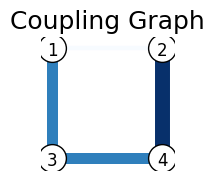

In [5]:
# create graph object
graph = nx.from_numpy_array(np.matrix(J), create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, {i: i + 1 for i in graph.nodes})
pos = {i: ((i-1) % cols, -((i-1) // cols)) for i in graph.nodes()}

# make edge widths proportional to edge weight
edge_widths = [
    (x + 1.5) ** 2 for x in list(nx.get_edge_attributes(graph, "weight").values())
]

# extract edge weights for colouring
edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())

plt.figure(figsize=(cols / 1.5, rows / 1.5))
nx.draw(
    graph, pos, node_color="white", with_labels=True, font_color="black", edge_cmap=plt.cm.Blues,
    node_size=400, width=edge_widths, horizontalalignment='center', edgecolors="black", edgelist=edges, 
    edge_color=weights, arrows=False, verticalalignment='center_baseline', font_size=12
)
plt.title('Coupling Graph', fontsize=18)
plt.show()

In [6]:
def build_hamiltonian(coupling_matrix):
    coeffs, ops = [], []
    ns = coupling_matrix.shape[0]

    for i, j in it.combinations(range(ns), r=2):
        coeff = coupling_matrix[i, j]
        if coeff:
            for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
                coeffs.append(coeff)
                ops.append(op(i) @ op(j))

    return qml.Hamiltonian(coeffs, ops)

In [7]:
# build sparse hamiltonian
H = build_hamiltonian(J)
# Hmat= H.sparse_matrix()
H_sparse = H.sparse_matrix()

# diagonalize
eigvals, eigvecs = sp.sparse.linalg.eigs(H_sparse, which='SR', k=2)
eigvals = eigvals.real
ground_state = eigvecs[:, np.argmin(eigvals)]
ground_state = ground_state/np.linalg.norm(ground_state)
ortho_state = eigvecs[:, np.argmax(eigvals)]
ortho_state = ortho_state/np.linalg.norm(ortho_state)

In [8]:
#create guided state
def create_guided_State(ground_state, ortho_state, epsilon=0.05):
    return np.sqrt(1-epsilon) * ground_state + np.sqrt(epsilon)*ortho_state

In [9]:
guided_state = create_guided_State(ground_state, ortho_state)


In [10]:
state0 = qml.math.dm_from_state_vector(guided_state)
state1 = qml.math.dm_from_state_vector(ground_state)
state2 = qml.math.dm_from_state_vector(ortho_state)

# Classical Shadow

In [11]:
def sample_shadow(statevector, wires, shots, device_name='default.qubit'):
    """ sample classical shadows for the state described by the statevector
    The resulting shadows are encoded as integer according to the logic
    0,1 -> +,- in the X Basis
    2,3 -> r,l in the Y Basis
    4,5 -> 0,1 in the Z Bassi
    """
    @qml.qnode(device=qml.device(device_name, wires=wires, shots=shots), diff_method=None, interface=None)
    def shadow_measurement():
        qml.QubitStateVector(statevector, wires=range(wires))
        return qml.classical_shadow(wires=range(wires))

    bits, recipes = shadow_measurement()

    # encode measurements and bases as integers
    data = 2 * recipes + bits
    data = np.array(data, dtype=int)

    return data


In [12]:
data = sample_shadow(ground_state, wires=wires, shots=10000)

In [13]:
#split data into bits outcomes and unitaries

recipes = data//2
bits = data - 2*recipes

shadow = qml.ClassicalShadow(bits=bits, recipes=recipes)

shadow_state = np.mean(shadow.global_snapshots(), axis=0)


In [14]:
def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    return int(np.ceil(N * K)), int(K)

In [15]:
#compare shadow_state with original one
np.allclose(state1, shadow_state, atol=1e-1)

True

# Alternating Layered Ansatz

In [16]:
# This is a test version without specifying the guided input state
def ALA(m, n, L, observables, dev):
    """
    Create alternating layered ansatz.

    Args: 
        m: number of qubits in one block
        n: number of qubits 
        L: depth of circuit
        dev: device
    Return:
        qml.QNode(circuit)
    """
    # we assume the number of qubits in one block could device the total number of qubits 
    assert n%m==0
    num_blocks = n//m
    wires = np.arange(n)
    gate_set = [qml.RX, qml.RY, qml.RZ]
    def circuit(weights):
        #qml.QubitStateVector(guided_state_vector, wires = range(n))

        for layer in range(L):
            if layer%2 == 0:
                block_start_qubits = np.arange(0, n, m)
                for block_id in range(num_blocks):
                    qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m])
                    qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='double')
                    qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='double_odd')
            else:
                block_start_qubits = [0]
                block_start_qubits.extend(np.arange(m//2, n-m//2, m))
                block_start_qubits.append(n-m//2)
                for block_id in range(num_blocks+1):
                    if block_id == 0 or block_id == num_blocks:
                        qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m//2])
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                            pattern='double')
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                        pattern='double_odd')
                    else:
                        qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m])
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                            pattern='double')
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                            pattern='double_odd')
            
        return [qml.expval(o) for o in observables]
    return qml.QNode(circuit, device=dev)
                    
            


In [17]:
import pennylane.numpy as qnp
n = 12
m = 4
L = 2
observables = [qml.PauliZ(i) for i in range(n)]
dev = qml.device("lightning.qubit", wires=np.arange(n))
param =  qnp.array(2*np.pi*rng.random(size = L * n), requires_grad=True)
circuit = ALA(m,n,L,observables, dev)


/tmp/ipykernel_3606612/2218079555.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


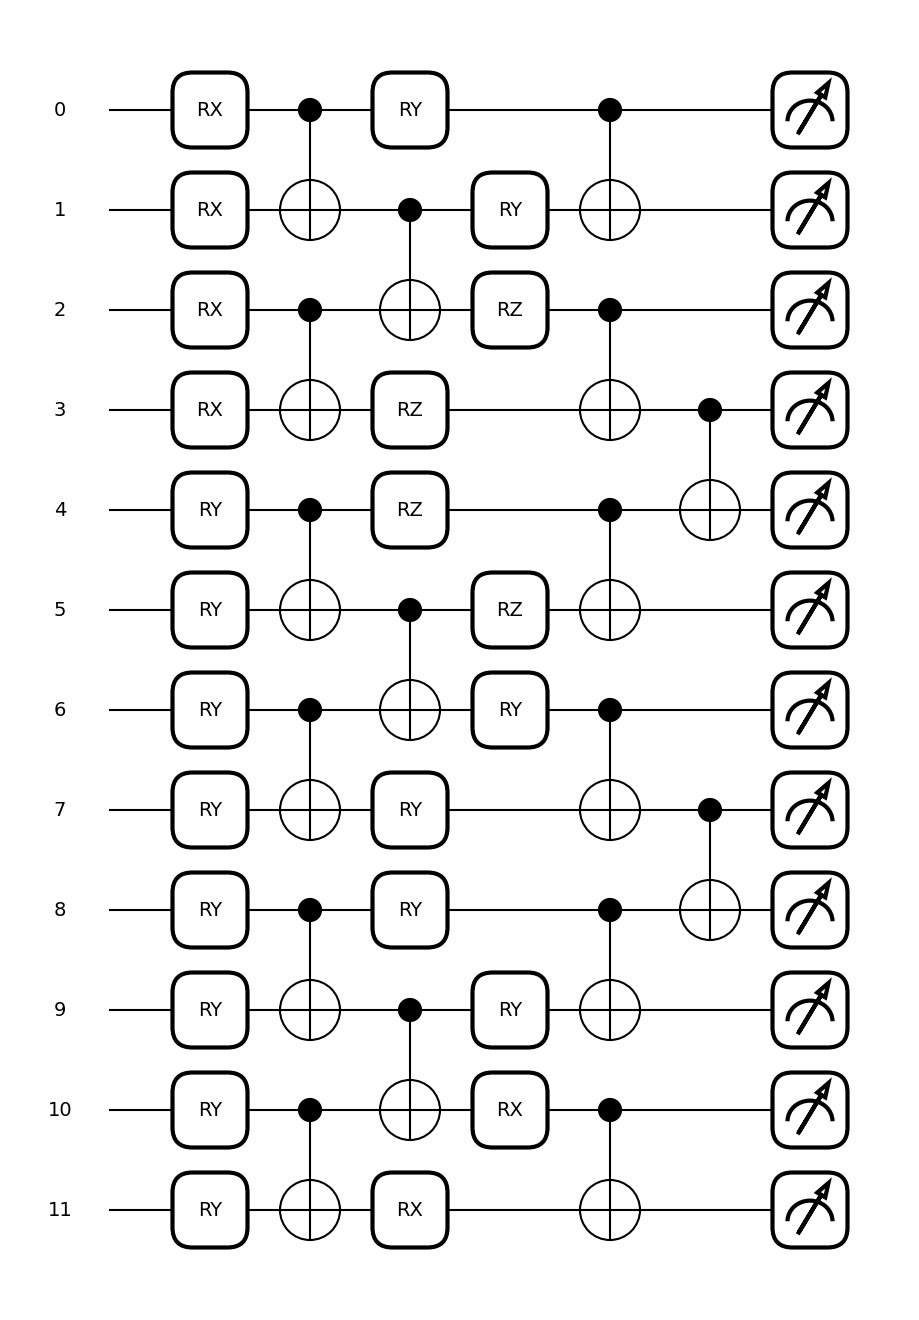

In [18]:
fig, ax = qml.draw_mpl(circuit)(param)
fig.show()

# Kernel Computation

In [19]:
def ALA(m, n, L, observables, dev):
    """
    Create alternating layered ansatz.

    Args: 
        m: number of qubits in one block
        n: number of qubits 
        L: depth of circuit
        observales: list of observables
        dev: device
    Return:
        qml.QNode(circuit)
    """
    # we assume the number of qubits in one block could device the total number of qubits 
    assert n%m==0
    num_blocks = n//m
    wires = np.arange(n)
    gate_set = [qml.RX, qml.RY, qml.RZ]
    def circuit(x, weights):
        qml.RX(x, wires=0)

        for layer in range(L):
            if layer%2 == 0:
                block_start_qubits = np.arange(0, n, m)
                for block_id in range(num_blocks):
                    qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m])
                    qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='double')
                    qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='double_odd')
            else:
                block_start_qubits = [0]
                block_start_qubits.extend(np.arange(m//2, n-m//2, m))
                block_start_qubits.append(n-m//2)
                for block_id in range(num_blocks+1):
                    if block_id == 0 or block_id == num_blocks:
                        qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m//2])
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                            pattern='double')
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                        pattern='double_odd')
                    else:
                        qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m])
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                            pattern='double')
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                            pattern='double_odd')
            
        return [qml.expval(o) for o in observables]
    return qml.QNode(circuit, device=dev)

In [20]:
from typing import Tuple
def local_result(
    n_qubits: int,
    x: np.ndarray,
    circuit: qml.QNode,
    params: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return the function value from the output and gradient w.r.t the parameters

    Args:
        n_qubits: number of qubits
        x: guided_state of x
        circuit: quantum circuit
        params: list of parameters
    Return:
        f_x, grad
         
    """

    # Compute fucntion value of the circuit
    # f_x = circuit(params)
    # f_x = np.sum(f_x)/np.sqrt(n_qubits)
    
    #Compute the gradient w.r.t parameters via parameter-shift rules
    grad = qml.gradients.param_shift(circuit)(x, params)
    grad = np.sum(np.array(grad), axis=0)/np.sqrt(n_qubits)
    
    return grad


In [21]:
def kernel_entry(
    x: np.ndarray, 
    x_prime: np.ndarray,
    n_qubits: int, 
    circuit: qml.QNode, 
    params: np.ndarray):
    """
    Calucate the kernel entry of x and x_prime

    Args: 
        x: guided_state w.r.t x
        x_prime: guided_state w.r.t x_prime
        n_qubits: number of qubits
        circuit: parameterized circuit
        params: training parameters
    Returns:
        the kernel entry of x, x_prime
    """
    # Compute the gradient of the function with input of x and x_prime
    grad_x = local_result(n_qubits, x, circuit, params)
    grad_x_prime = local_result(n_qubits, x_prime, circuit, params)

    # The kernel entry as the dot product between the two gradient vectors
    result = np.dot(grad_x, grad_x_prime)
    
    return result 

    

In [22]:
# Load two samples
# sample1 = np.load("/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, 10]_1000_test/sample_1/guided_state.npy")
# sample2 = np.load("/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, 10]_1000_test/sample_2/guided_state.npy")

In [23]:
n_list = [4,8,10,12,14,16,18,20, 22]
n_samples = 100 
m = 2
L = 1
x = np.pi/5
x_prime = np.pi/8

In [24]:
results= np.zeros((len(n_list), n_samples))
for i, n in enumerate(n_list):
    print("[INFO] Processing n={}".format(n))
    observables = [qml.PauliZ(i) for i in range(n)]
    dev = qml.device("lightning.qubit", wires=np.arange(n))
    circuit = ALA(m,n,L,observables, dev)
    for j in range(n_samples):
        param =  qnp.array(2*np.pi*rng.random(size = L * n), requires_grad=True)

        results[i, j] = kernel_entry(x, x_prime, n, circuit, param)



[INFO] Processing n=4
[INFO] Processing n=8
[INFO] Processing n=10
[INFO] Processing n=12
[INFO] Processing n=14
[INFO] Processing n=16
[INFO] Processing n=18
[INFO] Processing n=20
[INFO] Processing n=22


In [25]:
results.shape

(9, 100)

In [26]:
#np.save("dataset/kernel_concentration2.npy", results)

In [27]:
new_results = results[:, :]

In [28]:
mean_results = np.mean(new_results, axis=1)


Text(0, 0.5, 'Kernel entry')

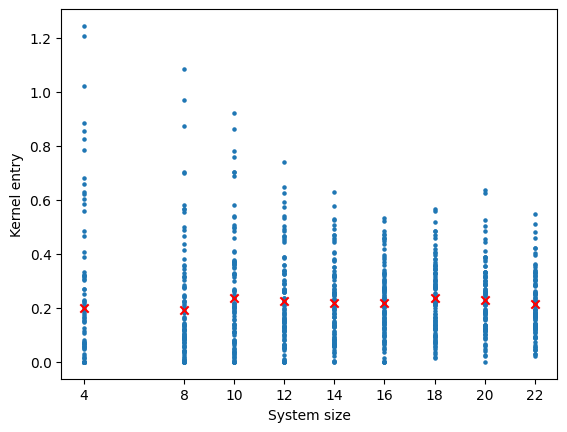

In [35]:
import matplotlib.pyplot as plt
x = [4,8,10,12,14,16,18,20, 22]
plt.scatter(np.repeat(x, 100), new_results.flatten(), s=5)
plt.scatter(x, mean_results, marker="x", c="r")
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("System size")
plt.xticks(x)
plt.ylabel("Kernel entry")



In [34]:
np.exp(-10*0.2**2)

0.6703200460356392

# Trainer

In [22]:
def ALA(m, n, L, observables, dev):
    """
    Create alternating layered ansatz.

    Args: 
        m: number of qubits in one block
        n: number of qubits 
        L: depth of circuit
        observales: list of observables
        dev: device
    Return:
        qml.QNode(circuit)
    """
    # we assume the number of qubits in one block could device the total number of qubits 
    assert n%m==0
    num_blocks = n//m
    wires = np.arange(n)
    gate_set = [qml.RX, qml.RY, qml.RZ]
    def circuit(guided_state_vector, weights):
        qml.QubitStateVector(guided_state_vector, wires = range(n))

        for layer in range(L):
            if layer%2 == 0:
                block_start_qubits = np.arange(0, n, m)
                for block_id in range(num_blocks):
                    qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m])
                    qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='double')
                    qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='double_odd')
            else:
                block_start_qubits = [0]
                block_start_qubits.extend(np.arange(m//2, n-m//2, m))
                block_start_qubits.append(n-m//2)
                for block_id in range(num_blocks+1):
                    if block_id == 0 or block_id == num_blocks:
                        qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m//2])
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                            pattern='double')
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m//2], \
                        pattern='double_odd')
                    else:
                        qml.broadcast(np.random.choice(gate_set, 1)[0], wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                        pattern='single', parameters=weights[layer*L+block_start_qubits[block_id]:layer*L+block_start_qubits[block_id]+m])
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                            pattern='double')
                        qml.broadcast(qml.CNOT, wires=wires[block_start_qubits[block_id]: block_start_qubits[block_id]+m], \
                            pattern='double_odd')
            
        return [qml.expval(o) for o in observables]
    return qml.QNode(circuit, device=dev)

In [23]:

def generate_true_properties( observables, dev):    
    def circuit(ground_state):
        qml.QubitStateVector(ground_state, wires=np.arange(n))
        return [qml.expval(o) for o in observables]
    return qml.QNode(circuit, dev)

# true_properties_generator = generate_true_properties(observables, dev2)


In [24]:
def cost_function(true_properties_generator, guided_states, ground_states, params):
    
    cost = 0
    for guided_state, ground_state in zip(guided_states, ground_states): 
        true_properties = true_properties_generator(ground_state)
        predictions = circuit(guided_state, params)

        f_x = np.sum(predictions)/np.sqrt(n)    
        y = np.sum(true_properties)/np.sqrt(n)     

        cost += (f_x-y)**2  
    
    cost /= 2*(len(guided_states))
    return cost 

In [25]:
kernels = np.zeros((9, 50))
for i, n in enumerate([4,6,8,10,12,14,16,18,20]):
    print("[INFO]-----------Processing n={}-------------".format(n))
    #loading two samples from the dataset
    guided_state_1 = np.load("/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, {}]_1000_test/sample_1/guided_state.npy".format(int(n/2)))
    ground_state_1 = np.load("/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, {}]_1000_test/sample_1/ground_state.npy".format(int(n/2)))
    guided_state_2 = np.load("/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, {}]_1000_test/sample_2/guided_state.npy".format(int(n/2)))
    ground_state_2 = np.load("/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, {}]_1000_test/sample_2/ground_state.npy".format(int(n/2)))
    # create a circuit
    opt = qml.GradientDescentOptimizer(stepsize=1e-3)
    m = 2
    L = 1
    num_iterations  = 50 # number of gradient descent steps
    observables = [qml.PauliZ(i) for i in range(n)]
    dev1 = qml.device("lightning.qubit", wires=np.arange(n))
    dev2 = qml.device("lightning.qubit", wires=np.arange(n))
    circuit = ALA(m,n,L,observables, dev1)
    params = qnp.random.normal(0, 1/n**2, size=(L*n), requires_grad=True)
    # Initialized kernel
    kernels[i,0] = kernel_entry(guided_state_1, guided_state_2, n, circuit, params)
    # compute true properties of the ground state
    true_properties_generator = generate_true_properties(observables, dev2)
    

    # # Trainer
    inital_cost = []
    # #initial cost
    inital_cost.append(cost_function(true_properties_generator, [guided_state_1, guided_state_2], [ground_state_1, ground_state_2], params))
    for it in range(1, num_iterations):
        print("[INFO] Processing iteration {}/{}".format(it, num_iterations))
        print("Kernel_entry: {} ".format(kernels[i, it-1]))
        # update parameters according cost_function
        _, _, _ , params = opt.step(cost_function,true_properties_generator, [guided_state_1, guided_state_2], [ground_state_1, ground_state_2], params)
        # compute kernel at current iteration
        kernels[i,it] = kernel_entry(guided_state_1, guided_state_2, n, circuit, params)
        # compute cost
        # cost.append(cost_function(true_properties_generator, [guided_state_1, guided_state_2], [ground_state_1, ground_state_2], params))
    


[INFO]-----------Processing n=4-------------


FileNotFoundError: [Errno 2] No such file or directory: '/home/quaqnguy/analytic_qnn_GLH/dataset/2Dheisenberg_[2, 2]_1000_test/sample_1/guided_state.npy'

In [33]:
np.save("lazyness2.npy", kernels)

In [27]:
kernels = np.load("lazyness.npy")

In [43]:
def numerical_derivative(K):
    return np.array([(K[i]-K[i-1])/2 for i in range(1, len(K))])

In [38]:
np.max(np.array(all_data), axis=1)

array([6.10890887e-03, 8.26677477e-04, 8.41443403e-04, 3.76909593e-04,
       2.86402394e-04, 3.36231834e-05, 6.29117275e-05, 1.76960688e-04,
       2.78143844e-05])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


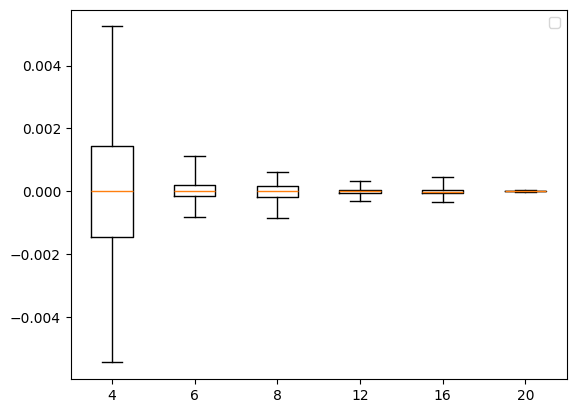

In [44]:
from scipy.interpolate import make_interp_spline, BSpline
ns = [4,6,8,12,16,20]
all_data = [numerical_derivative(kernels[i]) for i in range(len(ns))]

plt.boxplot(all_data, whis=4)
plt.xticks(np.arange(1, len(ns)+1), ns)
plt.legend()
    

# Asymptotic Results

In [33]:
train_dir = "/data/quaqnguy/GLH_Data/dataset/2Dheisenberg_[2, 10]_1000_train/"
test_dir = "/data/quaqnguy/GLH_Data/dataset/2Dheisenberg_[2, 10]_1000_test/"

n= 20
m = 2
L = 4
std = 0.01
step_size = 1
opt = qml.GradientDescentOptimizer(stepsize=step_size)

num_iterations  = 100 # number of gradient descent steps
observables = [qml.PauliZ(i) for i in range(n)]
dev1 = qml.device("lightning.qubit", wires=np.arange(n))
dev2 = qml.device("lightning.qubit", wires=np.arange(n))
true_properties_generator = generate_true_properties(observables, dev2)
circuit = ALA(m,n,L,observables, dev1)
params = qnp.random.normal(0, std, size=(L*n), requires_grad=True)
initial_params = params.copy()
true_model_params = params.copy()
linear_model_params = params.copy()
train_data_paths = os.listdir(train_dir)
test_data_paths = os.listdir(test_dir)


In [34]:
from typing import Tuple
def local_result(
    n_qubits: int,
    x: np.ndarray,
    circuit: qml.QNode,
    params: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return the function value from the output and gradient w.r.t the parameters

    Args:
        n_qubits: number of qubits
        x: guided_state of x
        circuit: quantum circuit
        params: list of parameters
    Return:
        f_x, grad
         
    """

    # Compute fucntion value of the circuit
    f_x = circuit(x, params)
    f_x = np.sum(f_x)/np.sqrt(n_qubits)
    
    #Compute the gradient w.r.t parameters via parameter-shift rules
    grad = qml.gradients.param_shift(circuit)(x, params)
    grad = np.sum(np.array(grad), axis=0)/np.sqrt(n_qubits)
    
    return f_x, grad

def get_target_values(
    path: str) -> float:
    """
    Compute the true properties from the ground state
    
    Args: 
        true_properties_generator: a quantum circuit to calculate the properties of the ground state
        path: a single data sample directory contains the groun_state.npy file
    """
    
    ground_state = np.load(os.path.join(train_dir, path, "ground_state.npy"))
    true_properties = true_properties_generator(ground_state)
    y = qnp.sum(true_properties)/np.sqrt(n)
    return y 

y = qnp.array([get_target_values(path) for path in train_data_paths])
y_test = qnp.array([get_target_values(path) for path in test_data_paths])
print(y.shape)
print(y_test.shape)

(80,)
(20,)


In [35]:
def linear_model(
    current_params: np.ndarray, 
    initial_params: np.ndarray, 
    initial_func: np.ndarray, 
    initial_grad: np.ndarray) -> np.ndarray:
    """
    Computer the function value at current parameter as linearized model: f_t = f_0 + (params_t - params_0)*grad_0

    Args:
        current_params: set of parameters at current time
        initial_params: set of parameters at initialization
        initial_func: initial function values at initialized parameters
        initial_grad: the gradient of the function w.r.t the initialized parameters
    Return:
        The function values of data at current time
    """

    f_t = initial_func + qnp.dot(initial_grad, (current_params - initial_params))
    return f_t

def true_model(
    params: np.ndarray, 
    data_path: str) -> float:

    guided_state = np.load(os.path.join(train_dir, data_path, "guided_state.npy"))
    predictions = circuit(guided_state, params)
    return qnp.sum(predictions)/qnp.sqrt(n)

def true_model_cost_func(
    params: np.ndarray,
    y: np.ndarray,
    data_paths: list) -> float:
    """
    Compute loss of function at the current time
    
    Args:
        y: the true properties of the data
        data_paths: list of directories of the data
    Return:
        The MSE loss
    """
    f_t = qnp.array([true_model(params, path) for path  in data_paths])
    return 1/2 * qnp.mean((y-f_t)**2)


def linear_model_cost_func(
    params: np.ndarray,
    y: np.ndarray,
    initial_params: np.ndarray, 
    initial_func: np.ndarray, 
    initial_grad: np.ndarray) -> float:
    """
    Compute loss of function at the current time
    
    Args:
        y: the true properties of the data
        data_paths: list of directories of the data
    Return:
        The MSE loss
    """
    f_t = linear_model(params, initial_params, initial_func, initial_grad)
    return 1/2 * qnp.mean((y-f_t)**2)

    
    

In [36]:
# comppute initialized function values and initialized gradients
initial_func = []
initial_grad = []

for name in train_data_paths:
    guided_state = np.load(os.path.join(train_dir, name, "guided_state.npy"))
    f, grad = local_result(n,guided_state,circuit, initial_params)
    initial_func.append(f)
    initial_grad.append(grad)

initial_func = np.array(initial_func)
initial_grad = np.array(initial_grad)

In [37]:
true_model_cost = []
linear_model_cost = []

true_model_cost_test = []
# linear_model_cost_test = []
# #initial cost
true_model_cost.append(true_model_cost_func(params, y, train_data_paths))
linear_model_cost.append(linear_model_cost_func(params, y, initial_params, initial_func, initial_grad))
for it in range(0, num_iterations):
    print("[INFO] Processing iteration {}/{}".format(it, num_iterations))
    # update parameters according true cost function
    true_model_params = opt.step(true_model_cost_func,true_model_params, y, train_data_paths)[0]
    true_model_cost.append(true_model_cost_func(true_model_params, y, train_data_paths))
    
    # update parameters according the linear model cost function
    linear_model_params = opt.step(linear_model_cost_func,linear_model_params, y, initial_params, initial_func, initial_grad)[0]
    linear_model_cost.append(linear_model_cost_func(linear_model_params, y, initial_params, initial_func, initial_grad))

    # Calculate test errors
    true_model_cost_test.append(true_model_cost_func(true_model_params, y_test, test_data_paths))
    #linear_model_cost_test.append(linear_model_cost_func(linear_model_params, y_test, initial_params, initial_func, initial_grad))
    if it %1 == 0:
        print("[INFO] Training True Model Cost: {} | Training Linear Model Cost: {} | Test True Model Cost: {}".format(true_model_cost[-1], linear_model_cost[-1], true_model_cost_test[-1]))
    

[INFO] Processing iteration 0/100
[INFO] Training True Model Cost: 0.005482059908554262 | Training Linear Model Cost: 0.005474078202600689 | Test True Model Cost: 0.005224566192337668
[INFO] Processing iteration 1/100
[INFO] Training True Model Cost: 0.005392428709779867 | Training Linear Model Cost: 0.005411380573432788 | Test True Model Cost: 0.005090244703184498
[INFO] Processing iteration 2/100
[INFO] Training True Model Cost: 0.0054709328965075995 | Training Linear Model Cost: 0.005349884780907617 | Test True Model Cost: 0.005024883047263435
[INFO] Processing iteration 3/100
[INFO] Training True Model Cost: 0.005395880279518892 | Training Linear Model Cost: 0.005289566670756736 | Test True Model Cost: 0.0049746738108839795
[INFO] Processing iteration 4/100
[INFO] Training True Model Cost: 0.005284361337187101 | Training Linear Model Cost: 0.005230402581900846 | Test True Model Cost: 0.004991908717583642
[INFO] Processing iteration 5/100
[INFO] Training True Model Cost: 0.005175310

In [ ]:
true_model_cost = np.array(true_model_cost)
linear_model_cost = np.array(linear_model_cost)
true_model_cost_test = np.array(true_model_cost_test)
# linear_model_cost_test = np.array(linear_model_cost_test)

np.save("/data/quaqnguy/GLH_Data/results/train_true_model_cost_L{}_m{}_std{}_stepsize{}.npy".format(L, m, std, step_size), true_model_cost)
np.save("/data/quaqnguy/GLH_Data/results/train_linear_model_cost_L{}_m{}_std{}_stepsize{}.npy".format(L, m, std, step_size), linear_model_cost)

np.save("/data/quaqnguy/GLH_Data/results/test_true_model_cost_L{}_m{}_std{}_stepsize{}.npy".format(L, m, std, step_size), true_model_cost_test)
# np.save("/data/quaqnguy/GLH_Data/results/test_linear_model_cost_L{}_m{}_std{}_stepsize{}.npy".format(L, m, std, step_size), linear_model_cost_test)

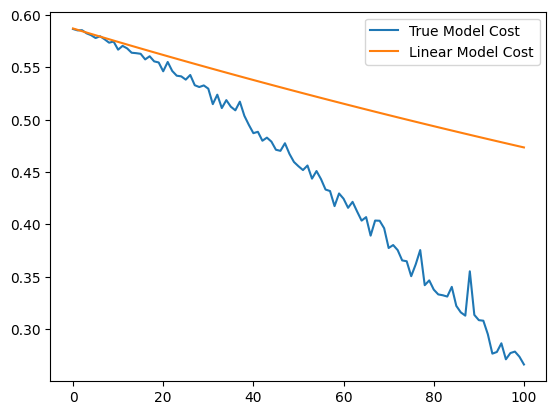

In [3]:
true_model_cost = np.load("/data/quaqnguy/GLH_Data/results/true_model_cost_2_2.npy")
linear_model_cost = np.load("/data/quaqnguy/GLH_Data/results/linear_model_cost_2_2.npy")
plt.plot(np.arange(101), true_model_cost, label="True Model Cost")
plt.plot(np.arange(101), linear_model_cost, label="Linear Model Cost")
plt.legend()